In [179]:
from IPython.display import display
import pandas as pd
import numpy as np
import os
from os import listdir
from os import path

import bs4 as bs
import requests
import pickle
import math

import datetime as dt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set()
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.2)
API_TOKEN = 'pk_248b202c0449443384770697855b70c5'
os.environ["IEX_TOKEN"] = API_TOKEN

In [180]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rstrip('\r\n'))

    with open("data/sp500_tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    return tickers

def load_sp500_tickers():
    try:
        with open("data/sp500_tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    except:
        tickers = save_sp500_tickers()
    return tickers


In [181]:
tickers = load_sp500_tickers()

## Longer Prediction 

In [196]:
def build_ticker_result(ticker, data_folder):
    scaled_result = pd.read_csv(data_folder + ticker + "_result.out", header=None)
    scaled_result.columns = ['open_p', 'close_p', 'high_p', 'low_p', 'volume_p']

    scaled_predict = pd.read_csv(data_folder + ticker + "_predict.out", header=None)
    scaled_predict.columns = ['open_p', 'close_p', 'high_p', 'low_p', 'volume_p']

    scaled_input = pd.read_csv(data_folder + ticker + "_input.out", header=None)
    scaled_input.columns = ['open', 'close', 'high', 'low', 'volume', 
                            'macd', 'signal', 'rsi', 'ibr', 'willamr', 
                            'mfi', 'roc_12', 'roc_25', 'cmf', 'cmo', 
                            'sma', 'ema', 'wma', 'trix', 'cci', 'dpo', 
                            'kst', 'dmi', 'bb', 'fi', 'eom']
    scaled_input = scaled_input[-len(scaled_result):]
    scaled_input.reset_index(inplace=True, drop=True)

    res = pd.DataFrame(np.concatenate((scaled_result, scaled_input.values), axis=1),
                      columns=np.concatenate((scaled_result.columns, scaled_input.columns)))
    res = res[res.columns[:10]]

    # Hint right last day close is shift(1)
    res['close_l'] = res.close.shift(1)
    res['close_p_l'] = res.close_p.shift(1)
    res['mom'] = (res.close - res.close_l) / res.close_l
    res['mom_p_abs'] = (res.close_p - res.close_l) / res.close_l
    res['mom_p_rel'] = (res.close_p - res.close_p_l) / res.close_p_l
    res['acc_abs'] = (res.mom * res.mom_p_abs > 0).astype(int)
    res['acc_rel'] = (res.mom * res.mom_p_rel > 0).astype(int)
    close_tomorrow = scaled_predict.values[0][2]
    close_today = scaled_input.values[-1][2]
    close_today_predict = scaled_result.values[-1][2]
    trend_abs = (close_tomorrow - close_today) * 100 / close_today
    trend_rel = (close_tomorrow - close_today_predict) * 100 / close_today_predict
    return (res, trend_abs, trend_rel)

In [208]:
tickers = load_sp500_tickers()
data_folder = "data/model_result_new/"
info = []
for ticker in tqdm(tickers[0:400]):
    if path.exists(data_foder + ticker + "_input.out") & path.exists(data_foder + ticker + "_result.out"):
        res, trend_abs, trend_rel = build_ticker_result(ticker, data_folder)
        res_tar = res[res.mom > 0.01]
        acc_abs = sum(res.acc_abs) * 100 / len(res)
        acc_rel = sum(res.acc_rel) * 100 / len(res)
        acc_best = max(acc_abs, acc_rel)
        acc_tar_abs = sum(res_tar.acc_abs) * 100 / len(res_tar)
        acc_tar_rel = sum(res_tar.acc_rel) * 100 / len(res_tar)
        acc_tar_best = max(acc_tar_abs, acc_tar_rel)
        info.append((ticker, 
                     acc_best, 
                     acc_tar_best,
                     trend_abs,
                     trend_rel,
                     len(res_tar),
                     acc_abs, 
                     acc_rel, 
                     acc_tar_abs, 
                     acc_tar_rel))
        #display(res)


100%|██████████| 400/400 [00:24<00:00, 16.35it/s]


In [209]:
result = pd.DataFrame(info, 
                      columns=['ticker', 'best_acc', 'best_tar_acc', 'trend_abs', 'trend_rel', 
                               'target_days', 'abs_acc', 'rel_acc', 'abs_tar_acc', 'abs_rel_acc'])
display(result.describe())

,best_acc,best_tar_acc,trend_abs,trend_rel,target_days,abs_acc,rel_acc,abs_tar_acc,abs_rel_acc
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,65.030972,78.222020,-0.919057,-1.013719,45.780488,55.709204,64.518002,46.272675,70.814087
std,3.448787,11.731918,2.666482,1.744501,15.141958,8.064947,3.433567,37.703645,6.958595
min,55.555556,54.687500,-8.601219,-10.074434,15.000000,38.095238,55.555556,0.000000,44.000000
25%,62.698413,69.444444,-2.285908,-1.983056,35.000000,49.206349,61.904762,5.714286,66.666667
50%,65.079365,75.782014,-0.970287,-1.031434,44.500000,55.357143,64.285714,45.664160,70.833333
75%,67.460317,85.464231,0.420786,0.075234,55.000000,61.904762,67.063492,83.051948,75.609756
max,74.206349,100.000000,27.534806,5.282237,108.000000,74.206349,73.412698,100.000000,92.857143


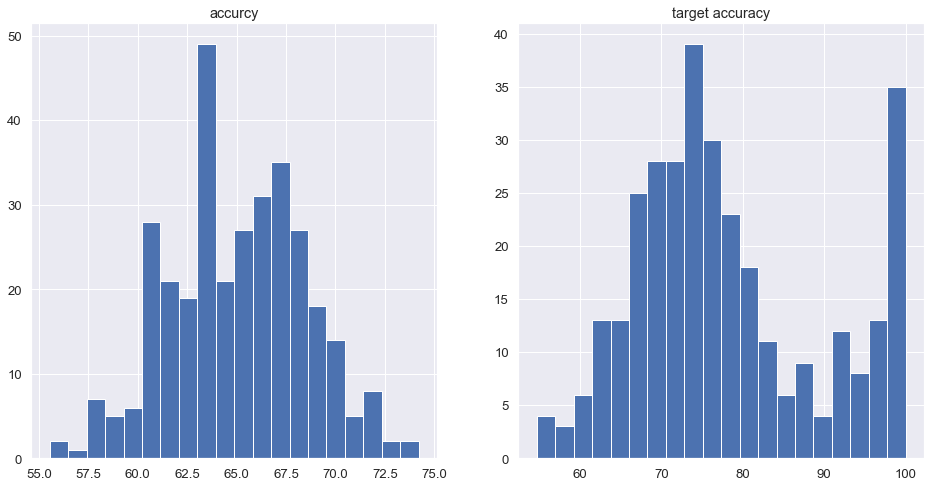

In [210]:
fig, axs = plt.subplots(1,2)
axs[0].hist(result.best_acc, bins=20)
axs[0].set_title('accurcy')
axs[1].hist(result.best_tar_acc, bins=20)
axs[1].set_title('target accuracy')
plt.show()

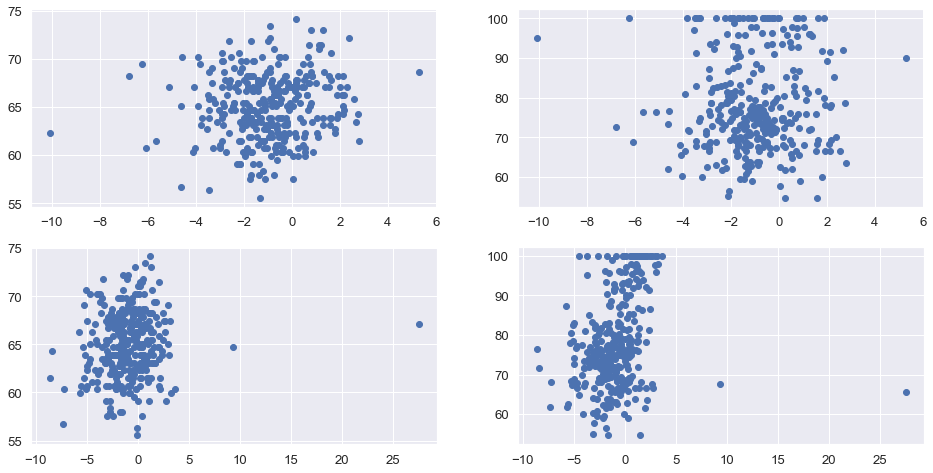

In [211]:
fig, axs = plt.subplots(2,2)
axs[0][0].scatter(result.trend_rel, result.best_acc)
axs[0][1].scatter(result.trend_rel, result.best_tar_acc)
axs[1][0].scatter(result.trend_abs, result.best_acc)
axs[1][1].scatter(result.trend_abs, result.best_tar_acc)
plt.show()

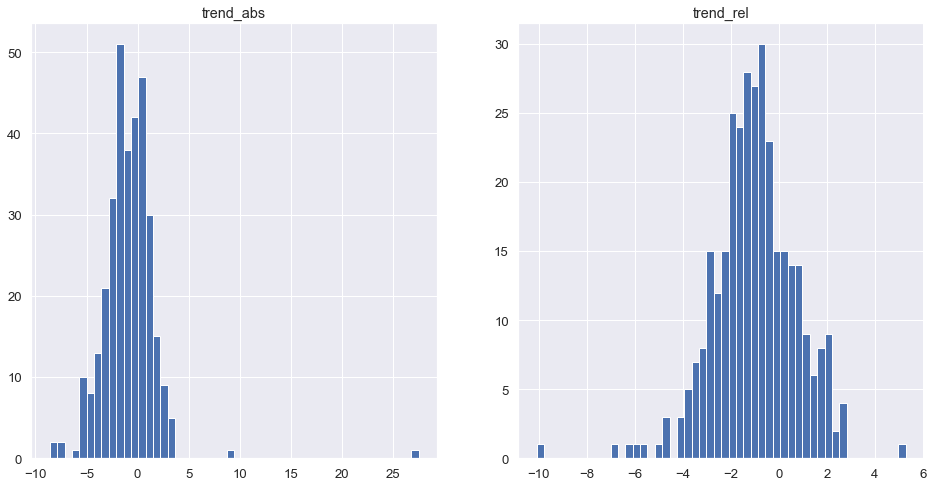

In [212]:
fig, axs = plt.subplots(1,2)
axs[0].hist(result.trend_abs, bins=50)
axs[0].set_title('trend_abs')
axs[1].hist(result.trend_rel, bins=50)
axs[1].set_title('trend_rel')
plt.show()

In [213]:
def find_best_option(result):
    best_options = result[(result['best_tar_acc'] > 75) & 
                          (result['trend_rel'] > 2)].sort_values(
        by=['best_tar_acc'], ascending=False).head(10)
    return best_options

In [215]:
best_tickers = find_best_option(result)
best_tickers

,ticker,best_acc,best_tar_acc,trend_abs,trend_rel,target_days,abs_acc,rel_acc,abs_tar_acc,abs_rel_acc
131,DRE,63.492063,92.105263,2.068272,2.652728,38,63.492063,62.698413,92.105263,63.157895
24,AEE,64.285714,91.428571,2.362889,2.134365,35,61.904762,64.285714,91.428571,68.571429
176,GE,68.650794,90.000000,0.469583,5.282237,50,65.873016,68.650794,90.000000,62.000000
162,FE,67.063492,85.185185,0.811000,2.282009,54,67.063492,61.111111,85.185185,68.518519
142,ETR,64.285714,78.571429,1.336252,2.768011,28,62.698413,64.285714,78.571429,67.857143
281,NI,64.682540,78.125000,2.091854,2.163078,32,64.285714,64.682540,78.125000,68.750000
226,KMB,65.079365,77.777778,0.525997,2.118232,36,61.904762,65.079365,50.000000,77.777778


DRE


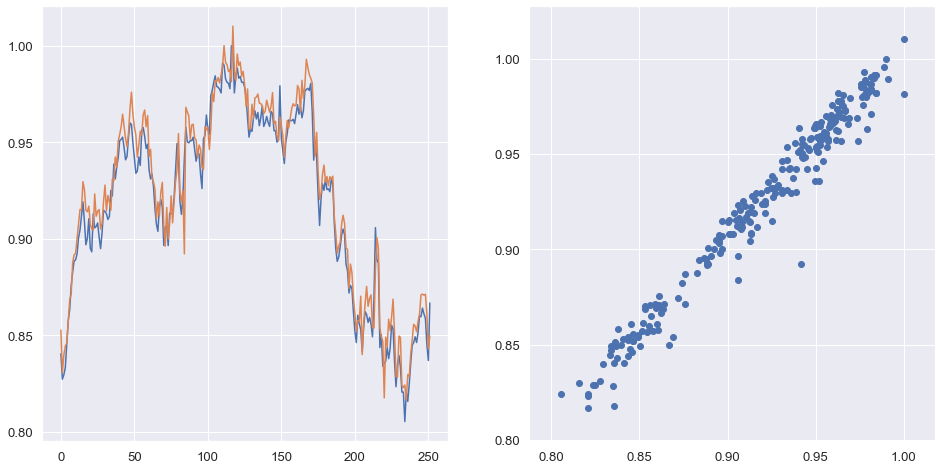

AEE


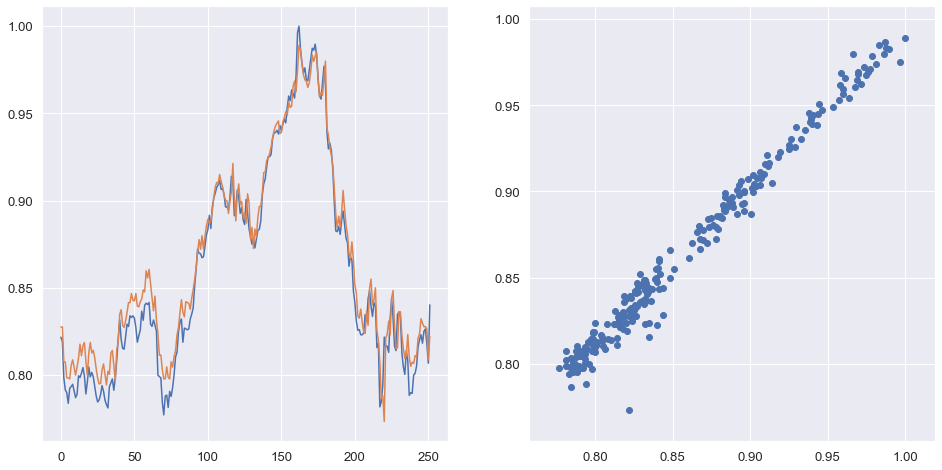

GE


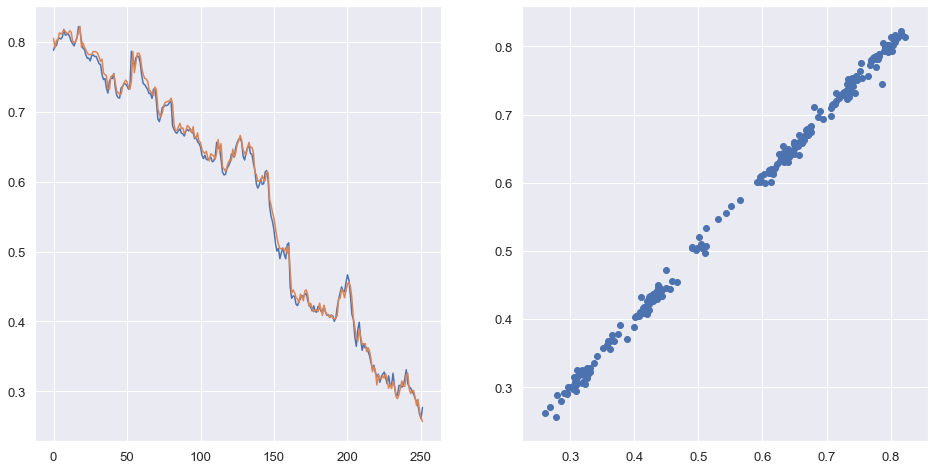

FE


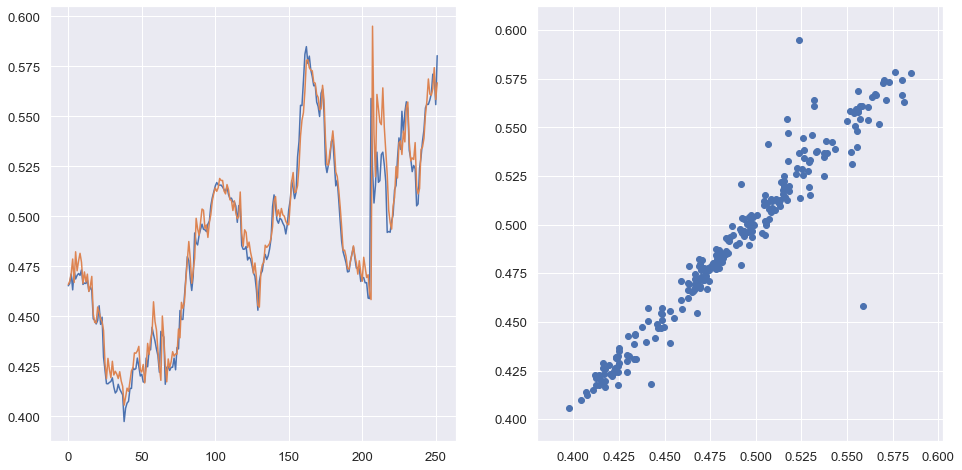

ETR


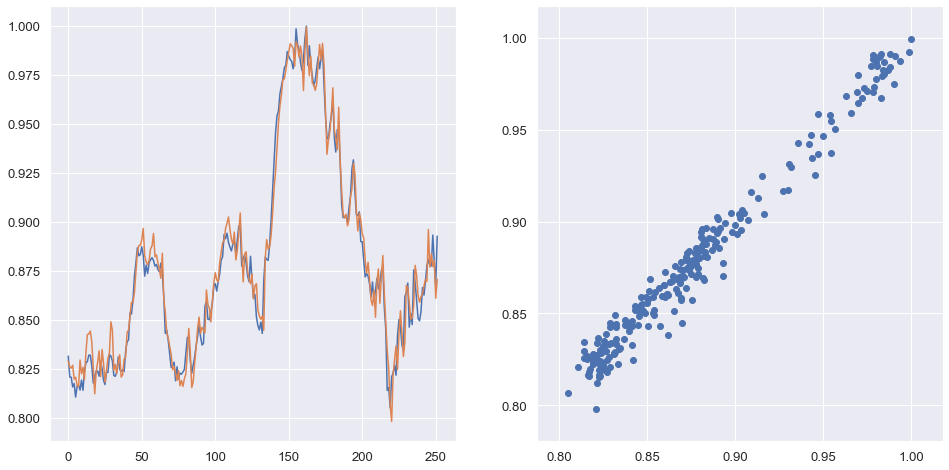

NI


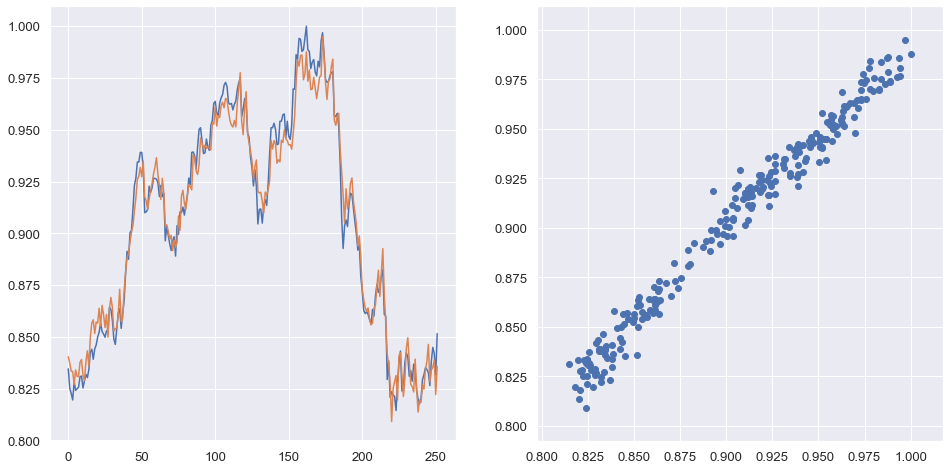

KMB


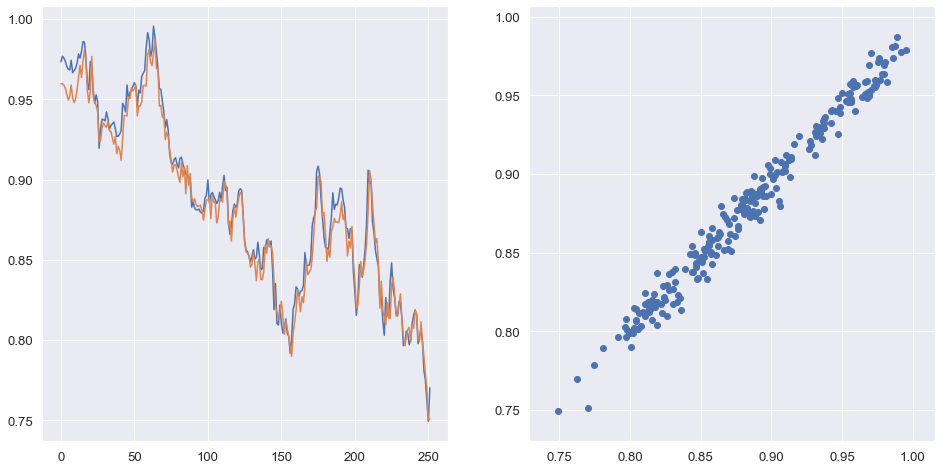

In [217]:
for ticker in best_tickers['ticker'].values:
    print (ticker)
    res, _, _ = build_ticker_result(ticker, data_foder)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(res[['close', 'close_p']])
    axs[1].scatter(res.close, res.close_p)
    plt.show()

,ticker,best_acc,best_tar_acc,target_days,abs_acc,rel_acc,abs_tar_acc,abs_rel_acc
2,ABMD,61.507937,76.470588,68,44.444444,61.507937,5.882353,76.470588
3,ACN,63.888889,61.538462,26,39.682540,63.888889,0.000000,61.538462
4,ATVI,63.888889,69.117647,68,46.428571,63.888889,0.000000,69.117647
5,ADBE,61.507937,68.292683,41,41.269841,61.507937,0.000000,68.292683
10,A,65.476190,60.000000,35,42.857143,65.476190,5.714286,60.000000
17,ALGN,67.857143,82.812500,64,47.619048,67.857143,7.812500,82.812500
19,LNT,62.698413,60.000000,25,48.015873,62.698413,0.000000,60.000000
20,ALL,67.460317,80.000000,35,48.809524,67.460317,2.857143,80.000000
21,GOOGL,71.825397,68.888889,45,41.666667,71.825397,0.000000,68.888889
26,AEP,68.650794,72.000000,25,48.015873,68.650794,8.000000,72.000000


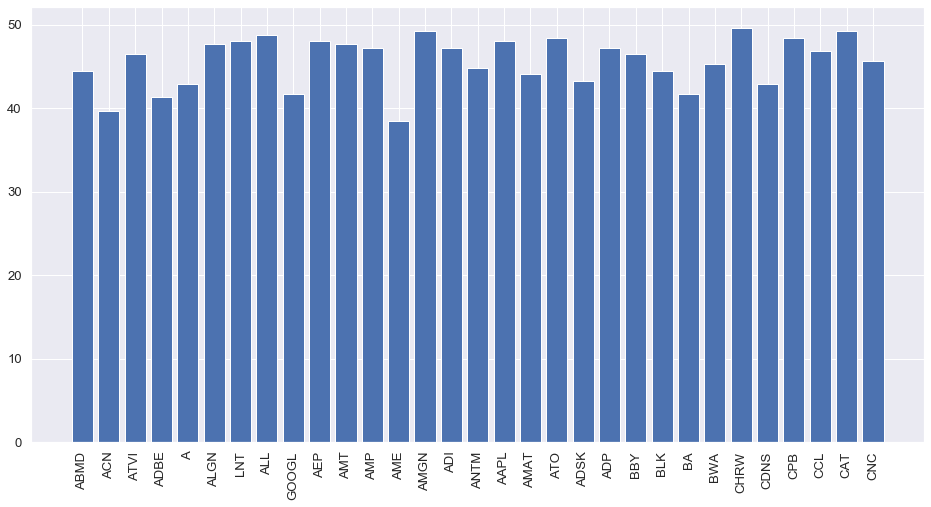

In [142]:
low_target_accuracy = result[(result.abs_acc < 50)]
display(low_target_accuracy)
plt.bar(x=low_target_accuracy.ticker, height=low_target_accuracy.abs_acc)
plt.xticks(rotation=90)
plt.show()